In [2]:
import numpy as np 
import pandas as pd  
import os 
from pathlib import Path 
import glob
import zipfile 
import random 

import seaborn as sns 
import matplotlib.pyplot as plt 

import tensorflow as tf  
from tensorflow.keras import layers
from tensorflow.keras import Model  
import keras_preprocessing
from keras_preprocessing import image   
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing.image import ImageDataGenerator

In [3]:
data_dir = Path('../input/cat-and-dog') 

train_dir = data_dir / "training_set/training_set" 
test_dir = data_dir / "test_set/test_set"

cat_samples_dir_train = train_dir / "cats" 
dog_samples_dir_train = train_dir / "dogs" 

def make_csv_with_image_labels(CATS_PATH, DOGS_PATH):  
    '''
    Function for making a dataframe that contains images path as well as their labels.
    Parameters:- 
     - CATS_PATH - Path for Cats  Images  
     - DOGS_PATH - Path for Dogs Images 
    Output:- 
    It simply returns dataframe  
    '''
    cat_images = CATS_PATH.glob('*.jpg')
    dog_images = DOGS_PATH.glob('*.jpg')
    
    df = [] 
    for i in cat_images: 
        df.append((i, 0)) 
    for j in dog_images: 
        df.append((i, 1))
    
    df = pd.DataFrame(df, columns=["image_path", "label"], index = None) 
    df = df.sample(frac = 1).reset_index(drop=True) 
    
    return df  

train_csv = make_csv_with_image_labels(cat_samples_dir_train,dog_samples_dir_train) 
train_csv.head()

,image_path,label
0,../input/cat-and-dog/training_set/training_set...,0
1,../input/cat-and-dog/training_set/training_set...,1
2,../input/cat-and-dog/training_set/training_set...,1
3,../input/cat-and-dog/training_set/training_set...,0
4,../input/cat-and-dog/training_set/training_set...,1


Total No. Of CAT Samples :-  4000
Total No. Of DOG Samples :-  4005


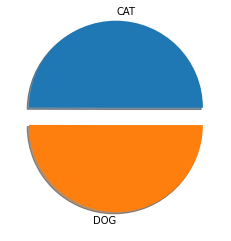

In [4]:
len_cat = len(train_csv["label"][train_csv.label == 0])
len_dog = len(train_csv["label"][train_csv.label == 1])

arr = np.array([len_cat , len_dog]) 
labels = ['CAT', 'DOG'] 
print("Total No. Of CAT Samples :- ", len_cat)
print("Total No. Of DOG Samples :- ", len_dog)

plt.pie(arr, labels=labels, explode = [0.2,0.0] , shadow=True) 
plt.show()

In [5]:
def get_train_generator(train_dir, batch_size=64, target_size=(224, 224)):  
    ''' 
    Function for preparing training data
    '''
    train_datagen = ImageDataGenerator(rescale = 1./255., # normalizing the image 
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True) 
    
    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = batch_size, 
                                                    color_mode='rgb',
                                                    class_mode = 'binary', 
                                                    target_size = target_size)   
    return train_generator  

train_generator = get_train_generator(train_dir) 

Found 8005 images belonging to 2 classes.


In [6]:
def get_testgenerator(test_dir,batch_size=64, target_size=(224,224)): 
    ''' 
    Function for preparing testing data
    '''
    test_datagen = ImageDataGenerator( rescale = 1.0/255. )
    test_generator  =  test_datagen.flow_from_directory(test_dir, 
                                                          batch_size  = batch_size, 
                                                          color_mode='rgb',
                                                          class_mode  = 'binary', 
                                                          target_size = target_size) 
    return test_generator

test_generator = get_testgenerator(test_dir)

Found 2023 images belonging to 2 classes.


In [7]:
# building the model 
model = tf.keras.Sequential([ 
    layers.Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape= (224,224,3),activation = 'relu'),
    layers.MaxPool2D(2,2), 
    layers.Conv2D(128, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    layers.MaxPool2D(2,2), 
    layers.Conv2D(256, (3,3), strides=(2,2),padding='same',activation = 'relu'), 
    layers.MaxPool2D(2,2),  
    layers.Flatten(), 
    layers.Dense(158, activation ='relu'), 
    layers.Dense(256, activation = 'relu'), 
    layers.Dense(128, activation = 'relu'), 
    layers.Dense(1, activation = 'sigmoid'), 
]) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [8]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=test_generator)

warnings ignored
Epoch 1/15
126/126 [==============================] - 117s 927ms/step - loss: 0.6851 - acc: 0.5718 - val_loss: 0.6760 - val_acc: 0.5378
Epoch 3/15
126/126 [==============================] - 117s 929ms/step - loss: 0.6533 - acc: 0.6313 - val_loss: 0.6210 - val_acc: 0.6624
Epoch 4/15
126/126 [==============================] - 118s 940ms/step - loss: 0.6212 - acc: 0.6506 - val_loss: 0.5557 - val_acc: 0.7123
Epoch 5/15
126/126 [==============================] - 118s 940ms/step - loss: 0.6128 - acc: 0.6592 - val_loss: 0.5382 - val_acc: 0.7341
Epoch 6/15
126/126 [==============================] - 124s 983ms/step - loss: 0.5853 - acc: 0.6998 - val_loss: 0.4984 - val_acc: 0.7647
Epoch 7/15
126/126 [==============================] - 124s 984ms/step - loss: 0.5730 - acc: 0.7027 - val_loss: 0.5394 - val_acc: 0.7202
Epoch 8/15
126/126 [==============================] - 117s 931ms/step - loss: 0.5627 - acc: 0.7048 - val_loss: 0.5158 - val_acc: 0.7444
Epoch 9/15
126/126 [===========

Text(0.5, 1.0, 'Training and validation loss')

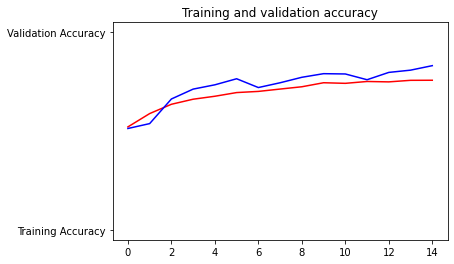

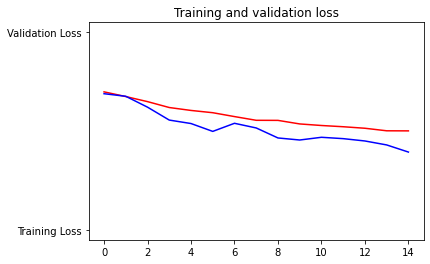

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')

In [12]:
model.save('my_model.h5')

In [14]:
model.save('my_model.h5')
new_model = tf.keras.models.load_model('./my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0